# Kickstarter Data Analysis

In [1]:
# Loading packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random

## Data Cleaning

### Initial Look at Features

Our initial look at the features of the data set consists of printing the head of the dataset as well as the summary statistics of the features to become familiar with the data we will be working with.

In [2]:
# Importing data
kickstarter2018 = pd.read_csv('../archive/ks-projects-201801.csv')

In [3]:
# First look at dataset
kickstarter2018.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,10/9/2015,1000.0,8/11/2015 12:12,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,11/1/2017,30000.0,9/2/2017 4:43,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2/26/2013,45000.0,1/12/2013 0:20,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,4/16/2012,5000.0,3/17/2012 3:24,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,8/29/2015,19500.0,7/4/2015 8:35,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
# Summarizing the catagrical variables before cleaning
kickstarter2018.describe(include=['object'])

,name,category,main_category,currency,deadline,launched,state,country
count,378657,378661,378661,378661,378661,378661,378661,378661
unique,375722,159,15,14,3164,347035,6,23
top,#NAME?,Product Design,Film & Video,USD,8/8/2014,6/20/2017 16:00,failed,US
freq,43,22314,63585,295365,705,15,197719,292627


In [5]:
# Summarizing numerical variables before cleaning
kickstarter2018.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


### Dealing with Null Values

Since we will be dropping the 'name' and 'usd pledged' variables, we do not need to deal with anu null values. We will not remove these null values because that would omit almost 4000 useable observations from the data set. 

In [6]:
# Counting missing values in each column
kickstarter2018.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

### Dealing With Date Strings

The data set has date variables 'deadline' and 'launched' which are mm/dd/yyyy formatted strings. We will need to convert these into datetime objects in order to retrieve useable imformation from them. Then we will take the difference betweeon 'deadline' and 'launched' to compute the number of days the project was live for. This will be stored in a new 'duration' variable. 

In [7]:
def convertDate(row):
    return(datetime.strptime(row, "%m/%d/%Y").date())

def convertDateTime(row):
    return(datetime.strptime(row, "%m/%d/%Y %H:%M").date())

def computeDuration(row):
    return (row['deadline'] - row['launched']).days

In [8]:
# Converting all date strings to datetime objects and computing the number of days it was live
kickstarter2018['deadline'] = kickstarter2018['deadline'].apply(convertDate)
kickstarter2018['launched'] = kickstarter2018['launched'].apply(convertDateTime)
kickstarter2018['duration'] = kickstarter2018[['deadline', 'launched']].apply(computeDuration, axis = 1)

In [9]:
# Removing unnecessary columns from dataset
kickstarter2018 = kickstarter2018[[
                                    'main_category',  
                                    'state', 
                                    'backers', 
                                    'country', 
                                    'usd_pledged_real', 
                                    'usd_goal_real',
                                    'duration'
                                 ]]

# Renaming columns for readability
kickstarter2018.rename(columns = {'usd_pledged_real' : 'pledged', 'usd_goal_real' : 'goal', 'main_category' : 'category'}, inplace = True)

### Changing State to Binary Variable

The 'state' variable has 6 levels. Our initial model will be predicting whether the projects suceeded or failed, so we will have to convert suspended and canceled to failed and remove observations that are live or undefined. We will be left with a binary 'state' variable.

In [10]:
kickstarter2018['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [11]:
# Converting suspended and canceled observations to failed
kickstarter2018['state'] = kickstarter2018['state'].replace({'suspended' : 'failed', 'canceled' : 'failed'}) 

In [12]:
# Dropping observations with live and undefined states
kickstarter2018 = kickstarter2018[(kickstarter2018['state'] != 'live') & (kickstarter2018['state'] != 'undefined')]

In [13]:
kickstarter2018['state'].unique()

array(['failed', 'successful'], dtype=object)

In [14]:
kickstarter2018.shape

(372300, 7)

## Exploratory Analysis and Visualization

### Summarizing Features after Cleaning

In [15]:
# Summarizing the catagrical variables after cleaning
kickstarter2018.describe(include=['object'])

,category,state,country
count,372300,372300,372300
unique,15,2,23
top,Film & Video,failed,US
freq,62399,238344,290887


In [16]:
kickstarter2018.describe()

,backers,pledged,goal,duration
count,372300.000000,3.723000e+05,3.723000e+05,372300.000000
mean,106.910040,9.148405e+03,4.572162e+04,34.456414
std,914.235813,9.170345e+04,1.151326e+06,66.448829
min,0.000000,0.000000e+00,1.000000e-02,1.000000
25%,2.000000,3.122000e+01,2.000000e+03,30.000000
50%,12.000000,6.280000e+02,5.500000e+03,30.000000
75%,57.000000,4.066000e+03,1.598542e+04,37.000000
max,219382.000000,2.033899e+07,1.663614e+08,16739.000000


In [17]:
kickstarter2018.columns

Index(['category', 'state', 'backers', 'country', 'pledged', 'goal',
       'duration'],
      dtype='object')

### Visualizing Numerical Data

Our correlation matrix indicates that pledged and backers are 0.75% correlated and none of out other numerical variables are significantly correlated.

In [18]:
# Visualizing the correlation matrix between numerical features.
kickstarter2018[['backers', 'pledged', 'goal', 'duration']].corr()

,backers,pledged,goal,duration
backers,1.000000,0.752478,0.004544,-0.000806
pledged,0.752478,1.000000,0.005643,0.000931
goal,0.004544,0.005643,1.000000,0.004194
duration,-0.000806,0.000931,0.004194,1.000000


After plotting voilin plots for the numerical features, we can clearly see that the data is very spread out. All the numerical variables contain outliers.

<AxesSubplot:xlabel='duration', ylabel='Count'>

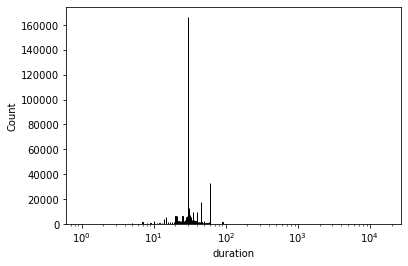

In [19]:
sns.histplot(kickstarter2018['duration'], log_scale = True, palette = 'rocket')

<AxesSubplot:>

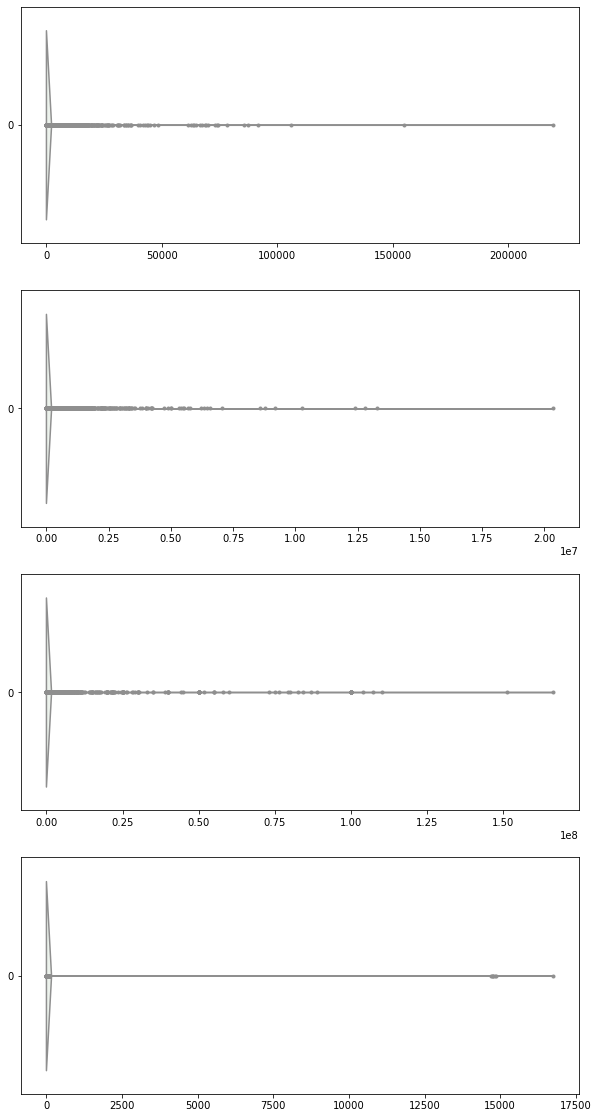

In [20]:
# initializing a figure with muiltiple plots
fig, axs = plt.subplots(nrows = 4, ncols = 1, figsize = (10, 20))

sns.violinplot(ax = axs[0], data = kickstarter2018['backers'], palette="light:g", inner="points", orient="h")
sns.violinplot(ax = axs[1], data = kickstarter2018['pledged'], palette="light:g", inner="points", orient="h")
sns.violinplot(ax = axs[2], data = kickstarter2018['goal'], palette="light:g", inner="points", orient="h")
sns.violinplot(ax = axs[3], data = kickstarter2018['duration'], palette="light:g", inner="points", orient="h")

<AxesSubplot:>

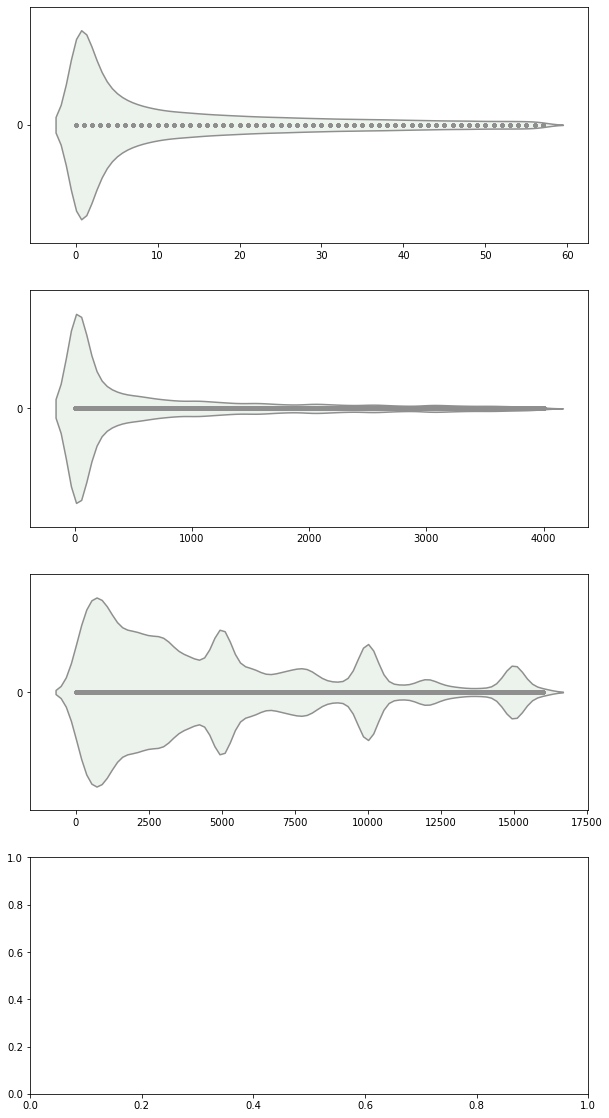

In [21]:
# initializing a figure with muiltiple plots
fig, axs = plt.subplots(nrows = 4, ncols = 1, figsize = (10, 20))

sns.violinplot(ax = axs[0], data = kickstarter2018[kickstarter2018['backers'] <= 57].backers, palette="light:g", inner="points", orient="h")
sns.violinplot(ax = axs[1], data = kickstarter2018[kickstarter2018['pledged'] <= 4000].pledged, palette="light:g", inner="points", orient="h")
sns.violinplot(ax = axs[2], data = kickstarter2018[kickstarter2018['goal'] <= 16000].goal, palette="light:g", inner="points", orient="h")
#sns.violinplot(ax = axs[3], data = kickstarter2018[kickstarter2018['duration'] <= 37].duration, palette="light:g", inner="points", orient="h")

In [22]:
#sns.violinplot(data = kickstarter2018[kickstarter2018['duration'] <= 37].duration)

In [23]:
kickstarter2018['goal']

0          1533.95
1         30000.00
2         45000.00
3          5000.00
4         19500.00
            ...   
378656    50000.00
378657     1500.00
378658    15000.00
378659    15000.00
378660     2000.00
Name: goal, Length: 372300, dtype: float64

### Removing Outliers

In [24]:
from scipy.stats import iqr

In [25]:
IQR = []
def removeOutliers(df, columnName):
    IQR = iqr(df[columnName])
    Q1 = np.quantile(df[columnName],0.25)
    Q3 = np.quantile(df[columnName],0.75)
    return(df[(df[columnName] > (Q1 - 1.5*IQR)) & (df[columnName] < (Q3 + 1.5*IQR))])

In [26]:
df = removeOutliers(kickstarter2018, 'backers')
df = removeOutliers(df, 'pledged')
df = removeOutliers(df, 'goal')
df = removeOutliers(df, 'duration')
kickstarter2018 = df

In [27]:
df.describe()

,backers,pledged,goal,duration
count,173932.000000,173932.000000,173932.000000,173932.000000
mean,18.338069,982.800392,6370.215880,30.702148
std,25.344730,1380.473852,7073.961279,3.117555
min,0.000000,0.000000,0.010000,23.000000
25%,1.000000,15.007500,1500.000000,30.000000
50%,7.000000,265.735000,3500.000000,30.000000
75%,26.000000,1490.647500,9000.000000,30.000000
max,139.000000,5482.000000,30720.080000,42.000000


In [28]:
# Resetting index after removing observations
kickstarter2018.reset_index(drop = True, inplace = True)

## Model Building

### Feature Scaling

Feature scaling is important for models that use Euclidian distances as well as for visualization and decreases training time. 

In [29]:
# Scaling the numerical data
from sklearn.preprocessing import MinMaxScaler

In [30]:
ss = MinMaxScaler()

# Subsetting numerical data
kickstarter2018_numerical = kickstarter2018[['backers', 'pledged', 'goal', 'duration']]

# Fitiing scaler to numerical data
scaler = ss.fit(kickstarter2018_numerical.values)

# Transforming numerical data with the scaler and placing back into dataset
kickstarter2018_numerical_scaled = scaler.transform(kickstarter2018_numerical.values)
kickstarter2018[['backers', 'pledged', 'goal', 'duration']] = kickstarter2018_numerical_scaled
kickstarter2018.describe()

,backers,pledged,goal,duration
count,173932.000000,173932.000000,173932.000000,173932.000000
mean,0.131929,0.179278,0.207363,0.405376
std,0.182336,0.251819,0.230272,0.164082
min,0.000000,0.000000,0.000000,0.000000
25%,0.007194,0.002738,0.048828,0.368421
50%,0.050360,0.048474,0.113932,0.368421
75%,0.187050,0.271917,0.292968,0.368421
max,1.000000,1.000000,1.000000,1.000000


### One Hot Encoding Categorical Data

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [32]:
# Subsetting categorical data
kickstarter_categorical = kickstarter2018[['category', 'country']]

In [33]:
encoder = OneHotEncoder(sparse = False)
encoded = encoder.fit_transform(kickstarter_categorical)
encoded_df = pd.DataFrame(encoded)

In [34]:
kickstarter2018 = kickstarter2018.join(encoded_df)
kickstarter2018.drop(['category', 'country'], axis = 1, inplace = True)

In [35]:
kickstarter2018

,state,backers,pledged,goal,duration,0,1,2,3,4,...,28,29,30,31,32,33,34,35,36,37
0,failed,0.007194,0.000182,0.162760,0.368421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,failed,0.000000,0.000000,0.078333,0.368421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,failed,0.000000,0.000000,0.162760,0.368421,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,failed,0.079137,0.121124,0.081380,0.368421,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,failed,0.115108,0.072054,0.048828,0.368421,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173927,failed,0.007194,0.004560,0.055338,0.368421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
173928,failed,0.028777,0.028092,0.211588,0.368421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
173929,failed,0.035971,0.028274,0.048828,0.210526,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
173930,failed,0.043165,0.036483,0.488280,0.421053,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Model Selection

In [36]:
# Creating x and y data frames
X = kickstarter2018.drop('state', axis = 1)
Y = kickstarter2018['state']

In [41]:
# Splitting training and test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 80000, test_size = 20000)

In [42]:
from sklearn import svm
svm_model = svm.SVC()

In [43]:
svm_model.fit(x_train, y_train)

SVC()

In [44]:
svm_model.score(x_test, y_test)

0.97875